In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = '/content/drive/MyDrive/Crime_Data_from_2020_to_Present_20250604.csv'



In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据，并只读取关键列
df = pd.read_csv(file_path, usecols=['DATE OCC', 'Crm Cd Desc'])

# 转换时间格式
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# 过滤时间段：2020年1月至8月
df_filtered = df[(df['DATE OCC'] >= '2020-01-01') & (df['DATE OCC'] <= '2020-08-31')]

# 创建 Year-Month 列
df_filtered['Month'] = df_filtered['DATE OCC'].dt.to_period('M').astype(str)

<ipython-input-57-3d1a604a3c62>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
<ipython-input-57-3d1a604a3c62>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DATE OCC'].dt.to_period('M').astype(str)


In [61]:
# 每月各类犯罪数量
crime_counts = df_filtered.groupby(['Month', 'Crm Cd Desc']).size().unstack(fill_value=0)

# 各类犯罪在每月的占比
crime_props = crime_counts.div(crime_counts.sum(axis=1), axis=0)

# 筛出前10大总犯罪类型（用于可视化）
top10_crimes = df_filtered['Crm Cd Desc'].value_counts().nlargest(10).index
df_top10 = df_filtered[df_filtered['Crm Cd Desc'].isin(top10_crimes)]
monthly_counts = df_top10.groupby(['Month', 'Crm Cd Desc']).size().unstack(fill_value=0)


monthly_totals = monthly_counts.sum(axis=1)
proportions_df = monthly_counts.div(monthly_totals, axis=0)
crime_props_top10 = proportions_df[top10_crimes]

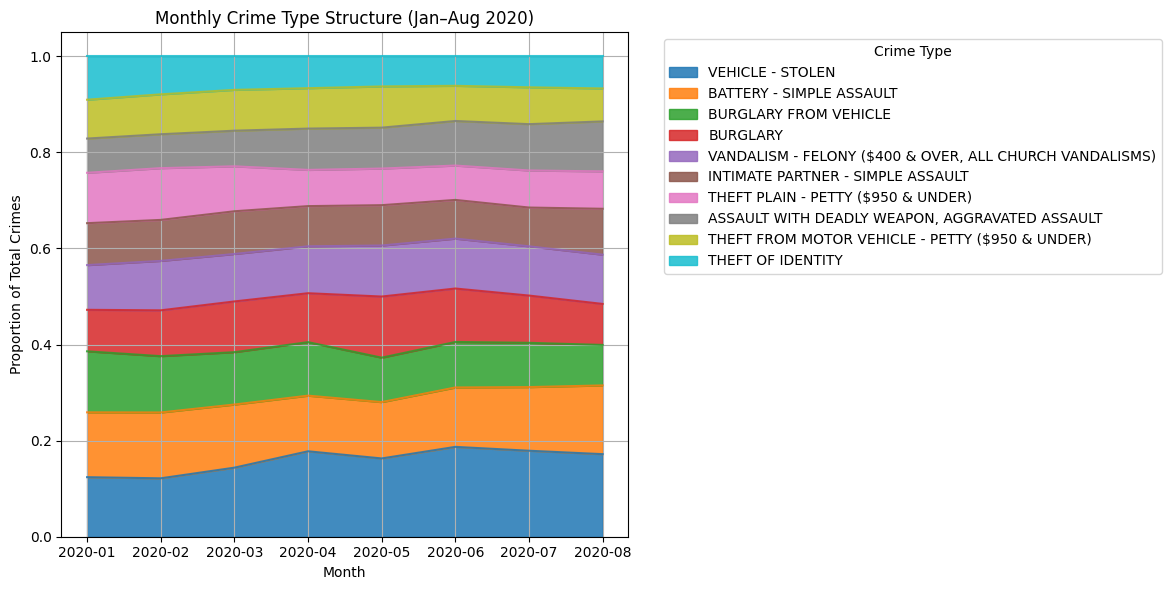

In [62]:
ax = crime_props_top10.plot(kind='area', figsize=(12, 6), alpha=0.85)
plt.title('Monthly Crime Type Structure (Jan–Aug 2020)')
plt.ylabel('Proportion of Total Crimes')
plt.xlabel('Month')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


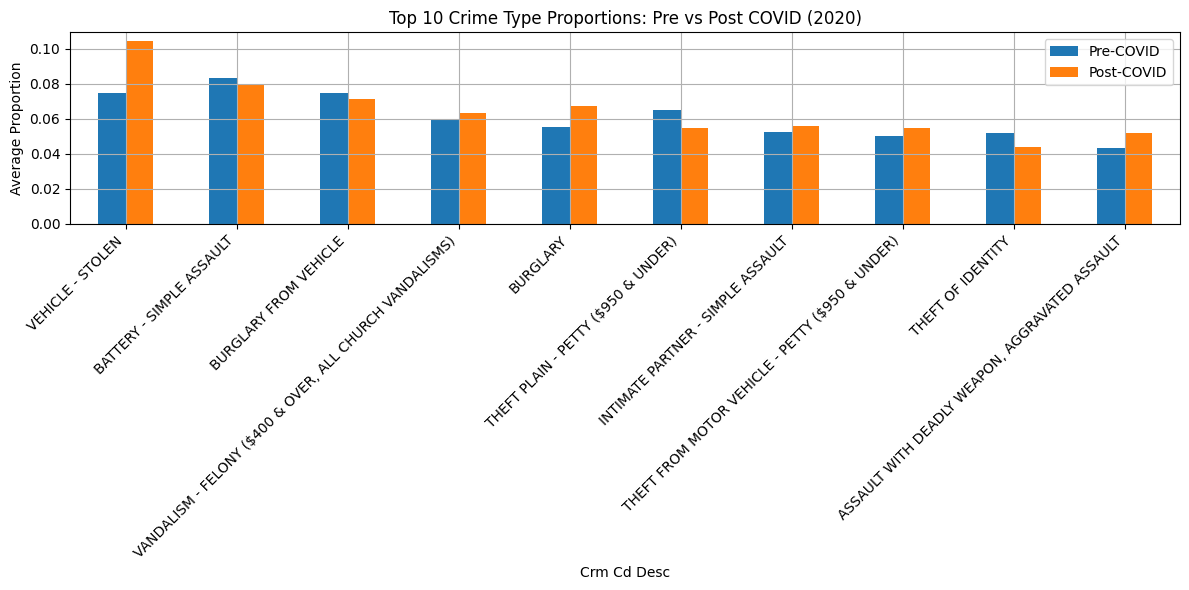

In [64]:

pre_covid_df = proportions_df.loc[['2020-01', '2020-02']]
post_covid_df = proportions_df.loc[['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08']]



# 对比图（仅 top 10 类型）
compare_df = pd.DataFrame({
    'Pre-COVID': pre_avg[top10_types],
    'Post-COVID': post_avg[top10_types]
})

compare_df.plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Crime Type Proportions: Pre vs Post COVID (2020)')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


In [65]:
pre_covid_df = proportions_df.loc[['2020-01', '2020-02']]
post_covid_df = proportions_df.loc[['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08']]


In [66]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types as ptypes

def analyze_structure_change(pre_df, post_df):
    results = []
    for col in pre_df.columns:
        pre_vals = pre_df[col].dropna()
        post_vals = post_df[col].dropna()
        t_stat, p_value = ttest_ind(pre_vals, post_vals, equal_var=False)
        pre_mean = pre_vals.mean()
        post_mean = post_vals.mean()
        delta = post_mean - pre_mean
        results.append({
            'Crm Cd Desc': col,
            'Pre-COVID Mean': round(pre_mean, 4),
            'Post-COVID Mean': round(post_mean, 4),
            'Δ (Post - Pre)': round(delta, 4),
            'T-statistic': round(t_stat, 3),
            'P-value': round(p_value, 4),
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    return pd.DataFrame(results).sort_values('P-value')

def display_results_table(df):
    from IPython.display import display
    display(df.style.background_gradient(cmap='RdYlGn_r', subset=['Δ (Post - Pre)']).format({
        'Pre-COVID Mean': '{:.3f}',
        'Post-COVID Mean': '{:.3f}',
        'Δ (Post - Pre)': '{:+.3f}',
        'T-statistic': '{:.2f}',
        'P-value': '{:.4f}'
    }))


In [68]:
results_df = analyze_structure_change(pre_covid_df, post_covid_df)
display_results_table(results_df)


,Crm Cd Desc,Pre-COVID Mean,Post-COVID Mean,Δ (Post - Pre),T-statistic,P-value,Significant
7,THEFT PLAIN - PETTY ($950 & UNDER),0.106,0.079,-0.028,8.07,0.0002,Yes
9,VEHICLE - STOLEN,0.123,0.170,+0.048,-7.48,0.0005,Yes
0,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0.071,0.090,+0.019,-4.45,0.0065,Yes
3,BURGLARY FROM VEHICLE,0.122,0.097,-0.025,3.79,0.0360,Yes
1,BATTERY - SIMPLE ASSAULT,0.136,0.127,-0.009,2.00,0.0963,No
2,BURGLARY,0.091,0.105,+0.014,-1.94,0.1172,No
6,THEFT OF IDENTITY,0.085,0.065,-0.019,3.39,0.1638,No
5,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0.082,0.079,-0.003,0.98,0.3633,No
8,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",0.098,0.102,+0.004,-0.77,0.5668,No
4,INTIMATE PARTNER - SIMPLE ASSAULT,0.086,0.086,-0.001,0.28,0.7887,No
